In [1]:
import os
import requests
import pandas as pd
from astropy.io import fits
from io import StringIO
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gamma
from scipy.optimize import minimize
from scipy.interpolate import RectBivariateSpline
import emcee
import corner
import scipy.io as sio
from ipywidgets import FloatProgress
from IPython.display import display
import time

In [2]:
stellarCatalog = "../stellarCatalogs/dr25_stellar_supp_gaia_clean_GKM.txt"
pcCatalog = "koiCatalogs/dr25_GKM_PCs.csv"

period_rng = (1, 400)
n_period = 100
rp_rng = (0.75, 10)
n_rp = 100

# for quick tests
nWalkers = 6
nBurnin = 200
nMcmc = 1000
# for production runs
#nWalkers = 100
#nBurnin = 1000
#nMcmc = 2000


model = "dualPowerLaw"
# which Radii lets you try with planet radii corrected for Gaia radii (whichRadii = "corrected")
# or with original KOI table planet radii (whichRadii = "kic")
whichRadii = "corrected"

In [3]:
def rateModel(x, y, xRange, yRange, theta, model):
    if model == "dualPowerLaw":
        f0, alpha, beta = theta
        ap1 = alpha+1;
        bp1 = beta+1;
        r = f0*(ap1*(x**alpha)/(xRange[1]**ap1-xRange[0]**ap1))*(bp1*(y**beta)/(yRange[1]**bp1-yRange[0]**bp1))
    else:
        raise ValueError('Bad model name');      
    return r

def getModelLabels(model):
    if model == "dualPowerLaw":
        return [r"$F_0$", r"$\beta$", r"$\alpha$"]
    else:
        raise ValueError('Bad model name');

def initRateModel(model):
    if model == "dualPowerLaw":
        f0 = 0.75
        alpha = -0.53218
        beta = -0.5
        theta = [f0, alpha, beta]
    else:
        raise ValueError('Bad model name');
  
    return theta

def lnPoisprior(theta, model):
    if model == "dualPowerLaw":
        if 0.0 <= theta[0] <= 5 \
        and -5.0 <= theta[1] <= 5.0 \
        and -5.0 <= theta[2] <= 5.0:
            return 1.0
    else:
        raise ValueError('Bad model name');
        
    # print(theta)
    return -np.inf

In [4]:
def medianAndErrorbars(data):
    if data.ndim > 1:
        dataResult = map(lambda v: (v[1], v[2]-v[1], v[1]-v[0]),
                             zip(*np.percentile(data, [16, 50, 84],
                                                axis=0)))
        dataResult = list(dataResult)
        return dataResult
    else:
        v = np.percentile(data, [16, 50, 84])
        return [v[1], v[2]-v[1], v[1]-v[0]]

def printMedianAndErrorbars(data):
    e = medianAndErrorbars(data)
    if data.ndim > 1:
        print("printMedianAndErrorbars only works for 1D arrays")
    else:
        return "{:.3f}".format(e[0]) +"^{+" + "{:.3f}".format(e[1]) + "}_{-" + "{:.3f}".format(e[2]) + "}"

In [5]:
from scipy.integrate import romb

def integrate2DGrid(g, dx, dy):
    if g.shape[0]%2 == 0 or g.shape[1]%2 == 0:
        raise ValueError('integrate2DGrid requires a grid with odd number of points on a side');
    return romb(romb(g, dx), dy)

def integrateRateModel(periodRange, rpRange, theta, model):
    nPts = 2**5+1 # must be 2**n + 1
    pGrid, rGrid = np.meshgrid(np.linspace(periodRange[0], periodRange[1], nPts), 
                                       np.linspace(rpRange[0], rpRange[1], nPts), indexing="ij")
    dp = (pGrid[1,0]-pGrid[0,0])
    dr = (rGrid[0,1]-rGrid[0,0])
    
    if theta.ndim == 1:
        y = rateModel(pGrid, rGrid, period_rng, rp_rng, theta, model)
        return integrate2DGrid(y, dp, dr)
    else: # assume first dimension is array of thetas
        ret = np.zeros(theta.shape[0])
        if len(ret) > 100:
            f = FloatProgress(min=0, max=len(ret))
            display(f)

        for i in range(len(ret)):
            y = rateModel(pGrid, rGrid, period_rng, rp_rng, theta[i,:], model)
            ret[i] = integrate2DGrid(y, dp, dr)
            if len(ret) > 100:
                f.value += 1
        return ret

def integratePopTimesComp(periodRange, rpRange, theta, model, compGrid):
    nP = compGrid.shape[0]
    nR = compGrid.shape[1]

    pGrid, rGrid = np.meshgrid(np.linspace(periodRange[0], periodRange[1], nP), 
                                       np.linspace(rpRange[0], rpRange[1], nR), 
                                       indexing="ij")
    dp = (pGrid[1,0]-pGrid[0,0])
    dr = (rGrid[0,1]-rGrid[0,0])
    y = rateModel(pGrid, rGrid, period_rng, rp_rng, theta, model)*compGrid
    return integrate2DGrid(y, dp, dr)

In [6]:
# population inference functions
def lnlike(theta):
    pop = rateModel(period_grid, rp_grid, period_rng, rp_rng, theta, model) * summedCompleteness
    pop = 0.5 * (pop[:-1, :-1] + pop[1:, 1:])
    norm = np.sum(pop * vol)
    ll = np.sum(np.log(rateModel(koi_periods, koi_rps, period_rng, rp_rng, theta, model))) - norm
    return ll if np.isfinite(ll) else -np.inf

# The ln-probability function is just propotional to the ln-likelihood
# since we're assuming uniform priors.
def lnprob(theta):
    lp = lnPoisprior(theta, model)
    if not np.isfinite(lp):
        return -np.inf

    return lnlike(theta)

# The negative ln-likelihood is useful for optimization.
# Optimizers want to *minimize* your function.
def nll(theta):
    ll = lnlike(theta)
    return -ll if np.isfinite(ll) else 1e15

In [7]:
def getRadii(catalog):
    if whichRadii == "corrected":
        return catalog.corrected_prad
    elif whichRadii == "kic":
        return catalog.koi_prad
    else:
        raise ValueError('Bad whichRadii string')

In [8]:
stellarTargets = pd.read_csv(stellarCatalog)
base_kois = pd.read_csv(pcCatalog)
m = (period_rng[0] <= base_kois.koi_period) & (base_kois.koi_period <= period_rng[1])
thisRadii = getRadii(base_kois)
m &= np.isfinite(thisRadii) & (rp_rng[0] <= thisRadii) & (thisRadii <= rp_rng[1])
    
kois = pd.DataFrame(base_kois[m])
allKois = kois

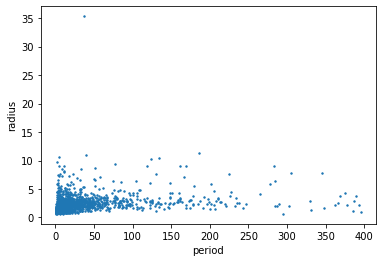

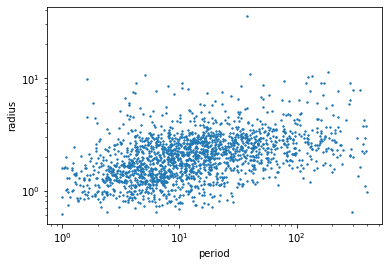

In [9]:
plt.figure()
plt.scatter(kois.koi_period, kois.koi_prad, s=2)
#plt.ylim(0, 5)
plt.xlabel('period')
plt.ylabel('radius')

plt.figure()
plt.scatter(kois.koi_period, kois.koi_prad, s=2)
plt.yscale('log')
plt.xscale('log')
plt.xlabel('period')
plt.ylabel('radius')
plt.show()

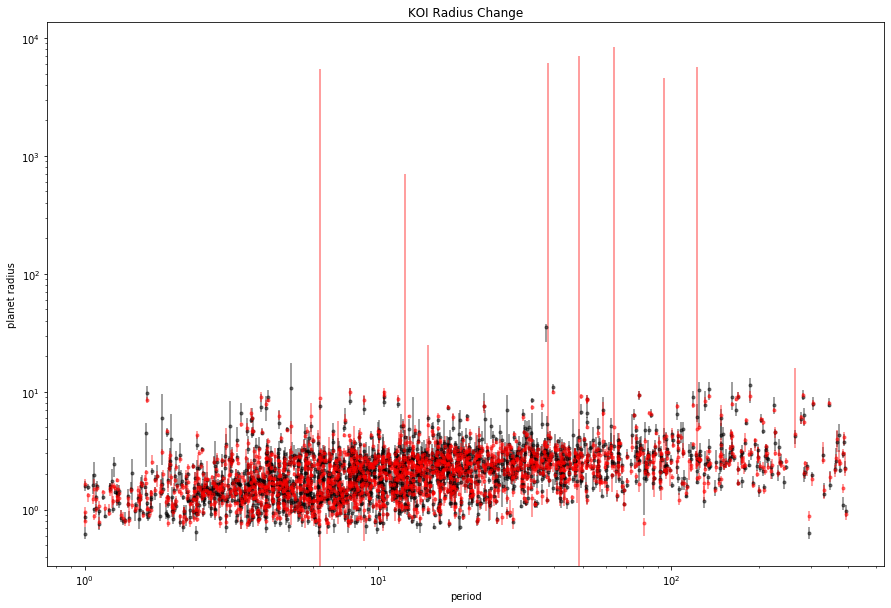

In [10]:
fig, ax = plt.subplots(figsize=(15,10))
ax.errorbar(kois.koi_period, kois.koi_prad, 
            yerr = [-kois.koi_prad_err2, kois.koi_prad_err1],
            fmt="k.", alpha = 0.5)
ax.errorbar(kois.koi_period, kois.corrected_prad, 
            yerr = [-kois.corrected_prad_err2, kois.corrected_prad_err1],
            fmt="r.", alpha = 0.5)

plt.xlabel("period")
plt.ylabel("planet radius")
plt.title("KOI Radius Change")
plt.yscale('log')
plt.xscale('log')
plt.show()

In [11]:
period = np.linspace(period_rng[0], period_rng[1], n_period)
rp = np.linspace(rp_rng[0], rp_rng[1], n_rp)
period_grid, rp_grid = np.meshgrid(period, rp, indexing="ij")
periodShape = period_grid.shape

In [12]:
inputgrid = "../completenessContours/out_sc0_GKM_baseline.fits.gz"

hdulist = fits.open(inputgrid)
cumulative_array = hdulist[0].data
kiclist = np.asarray(hdulist[1].data, dtype=np.int32)
probdet = np.transpose(cumulative_array[0])
probtot = np.transpose(cumulative_array[1])
prihdr = hdulist[0].header
min_comp_period = prihdr["MINPER"]
max_comp_period = prihdr["MAXPER"]
n_comp_period = prihdr["NPER"]
min_comp_rp = prihdr["MINRP"]
max_comp_rp = prihdr["MAXRP"]
n_comp_rp = prihdr["NRP"]
# print "KIC list length" + '{:6d}'.format(kiclist.size)
print(hdulist[0].header,)

period_want = np.linspace(min_comp_period, max_comp_period, n_comp_period)
rp_want = np.linspace(min_comp_rp, max_comp_rp, n_comp_rp)
period_want2d, rp_want2d = np.meshgrid(period_want, rp_want)

numCompVeInterp = RectBivariateSpline(period_want, rp_want, probtot)
numProbDetInterp = RectBivariateSpline(period_want, rp_want, probdet)

SIMPLE  =                    T / conforms to FITS standard                      BITPIX  =                  -64 / array data type                                NAXIS   =                    3 / number of array dimensions                     NAXIS1  =                 2000                                                  NAXIS2  =                 3001                                                  NAXIS3  =                    2                                                  EXTEND  =                    T                                                  MINPER  =                 0.01                                                  MAXPER  =                500.0                                                  NPER    =                 2000                                                  MINRP   =                 0.75                                                  MAXRP   =                 12.0                                                  NRP     =                 3001          

In [37]:
print(kiclist)

[  892834  1026165  1027536 ... 12885212 12934488 12935010]


In [13]:
summedCompleteness = numCompVeInterp(period, rp)
summedProbDet = numProbDetInterp(period, rp)

In [14]:
print(summedCompleteness.shape)
print(summedProbDet.shape)

(100, 100)
(100, 100)


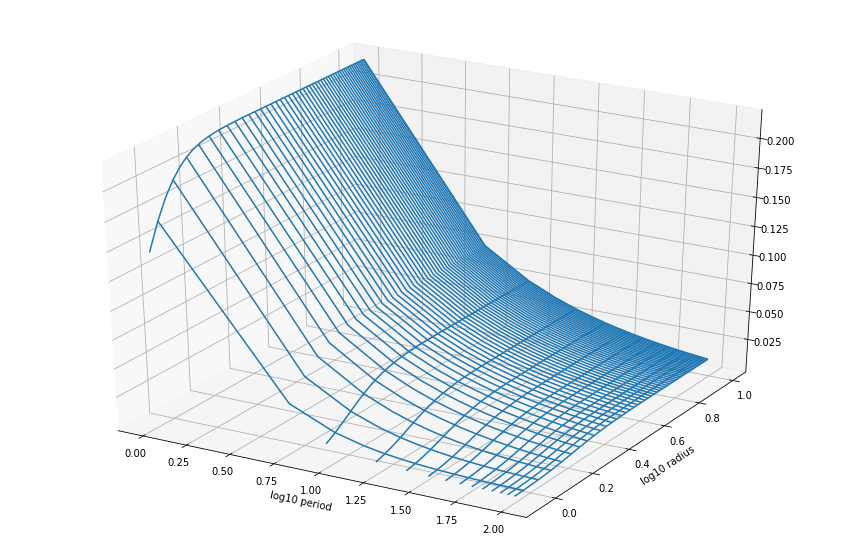

In [15]:
from mpl_toolkits.mplot3d import axes3d

fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot(111, projection='3d')

logp = np.log10(period_grid)
logr = np.log10(rp_grid)

cut_logp = logp.copy()
cut_logp[np.where(cut_logp > 2)] = np.nan

cut_logr = logr.copy()
cut_logr[np.where(cut_logr < -0.1)] = np.nan


ax.plot_wireframe(cut_logp, cut_logr, summedCompleteness / kiclist.size, rstride=2, cstride=2)
#ax.plot_surface(period_grid, rp_grid, summedProbDet)
#plt.xlim(0,100)  
#plt.ylim(0,1)  
ax.set_xlabel('log10 period')
ax.set_ylabel('log10 radius')
plt.show()

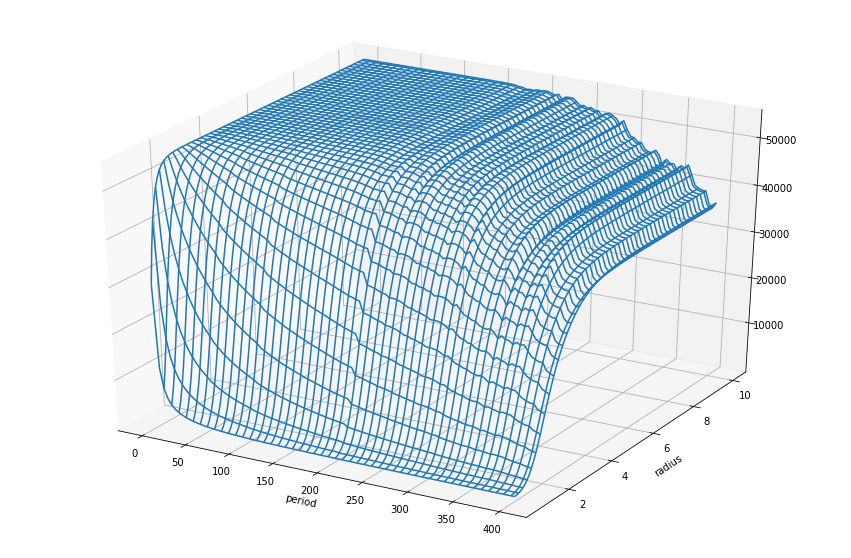

In [16]:
from mpl_toolkits.mplot3d import axes3d
fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot(111, projection='3d')

#ax.plot_wireframe(period_grid, rp_grid, summedCompleteness / kiclist.size, rstride=2, cstride=2)
ax.plot_wireframe(period_grid, rp_grid, summedProbDet)
ax.set_xlabel('period')
ax.set_ylabel('radius')
plt.show()

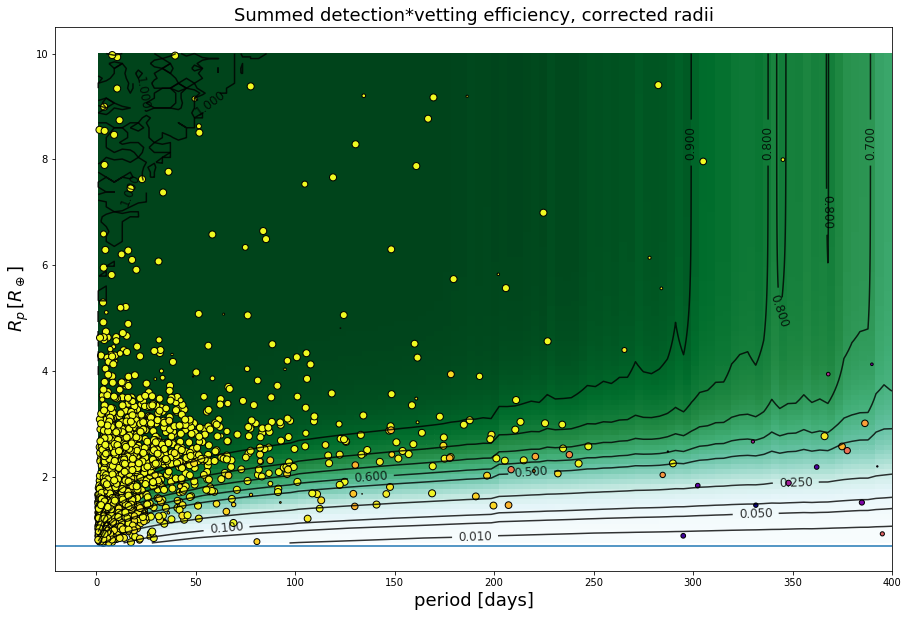

In [17]:
# contourLevels = np.arange(1e-2, 1, 5e-2)
contourLevels = [0.01, 0.05, 0.1, 0.25, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]

#fig, ax = plt.subplots(figsize=(15,10))
plt.figure(figsize=(15,10))
plt.pcolor(period_grid, rp_grid, summedProbDet, cmap="BuGn")
c = plt.contour(period_grid, rp_grid, summedProbDet / kiclist.size, contourLevels,
               colors="k", alpha=0.8)
scf = plt.scatter(kois.koi_period, getRadii(kois), cmap="plasma", 
               c=kois.reliability, edgecolors='k', s=50*kois.totalReliability, alpha = 1.0)

#cbh = plt.colorbar(scf)
#cbh.ax.set_ylabel("Instrumental FP Reliability")

#c = plt.contour(period_grid, rp_grid, numCompVe / kiclist.size, colors="k", alpha=0.8)
plt.clabel(c, fontsize=12, inline=1, fmt="%.3f")
plt.title("Summed detection*vetting efficiency, " + whichRadii + " radii", fontsize = 18)
plt.xlabel("period [days]", fontsize = 18)
plt.ylabel("$R_p \, [R_\oplus]$", fontsize = 18)
#plt.ylim(0, 10)
#plt.xlim(0,500)
plt.axhline(y=0.7)
#plt.savefig("summedCompleteness.pdf",bbox_inches='tight')
plt.show()

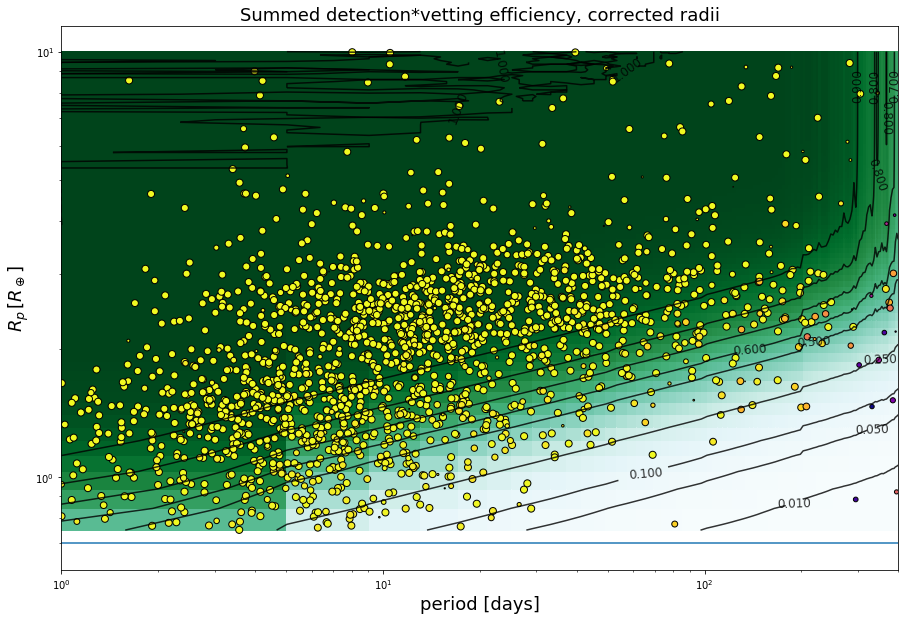

In [18]:
plt.figure(figsize=(15,10))

plt.pcolor(period_grid, rp_grid, summedProbDet, cmap="BuGn")
c = plt.contour(period_grid, rp_grid, summedProbDet / kiclist.size, contourLevels,
               colors="k", alpha=0.8)
scf = plt.scatter(kois.koi_period, getRadii(kois), cmap="plasma", 
               c=kois.reliability, edgecolors='k', s=50*kois.totalReliability, alpha = 1.0)

plt.clabel(c, fontsize=12, inline=1, fmt="%.3f")
plt.title("Summed detection*vetting efficiency, " + whichRadii + " radii", fontsize = 18)
plt.xlabel("period [days]", fontsize = 18)
plt.ylabel("$R_p \, [R_\oplus]$", fontsize = 18)
plt.yscale('log')
#plt.xlim(0.1, 500)
plt.xscale('log')
#plt.ylim(1, 10)
plt.axhline(y=0.7)

plt.show()

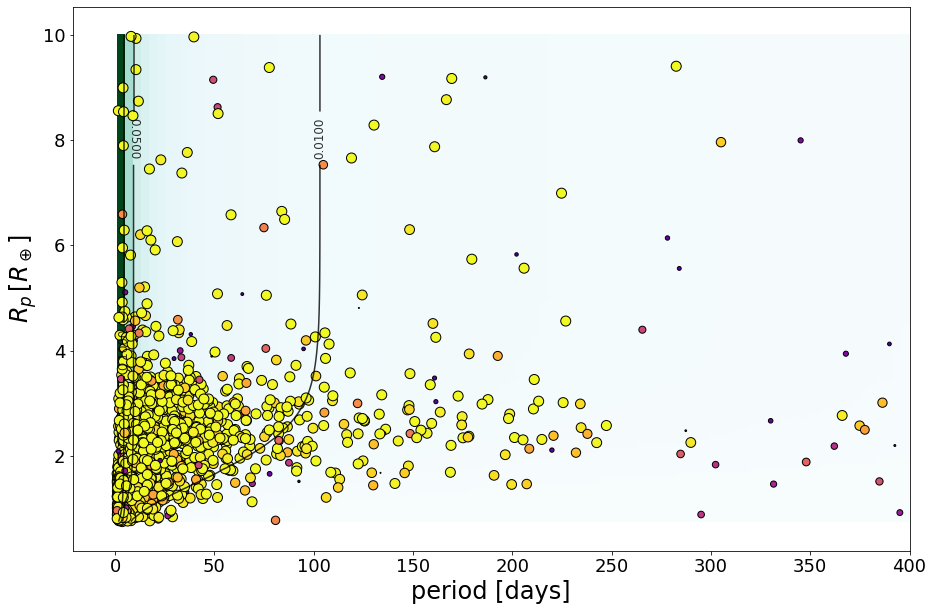

In [19]:
# contourLevels = np.arange(1e-2, 1, 5e-2)
#contourLevels = np.arange(1e-3, 1e-2, 1e-3)
#contourLevels = np.insert(contourLevels, 0, [1e-4, 5e-4])
contourLevels = [0.01, 0.05, 0.1, 0.25, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
plt.figure(figsize=(15,10))

plt.pcolor(period_grid, rp_grid, summedCompleteness, cmap="BuGn")
c = plt.contour(period_grid, rp_grid, summedCompleteness / kiclist.size, contourLevels,
               colors="k", alpha=0.8)
ax.errorbar(kois.koi_period, getRadii(kois), 
           yerr = [-kois.corrected_prad_err2, kois.corrected_prad_err1],
         fmt="none", ecolor="k", alpha = 0.15, marker = None)
scf = plt.scatter(kois.koi_period, getRadii(kois), cmap="plasma", 
               c=kois.totalReliability, edgecolors='k', s=100*kois.totalReliability, alpha = 1.0)

#cbh = plt.colorbar(scf);
#cbh.ax.set_ylabel("Reliability", fontsize = 24);

#c = plt.contour(period_grid, rp_grid, numCompVe / kiclist.size,
#               colors="k", alpha=0.8)
#plt.ylim(1, 10)
#plt.xlim(50, 400)
plt.clabel(c, fontsize=12, inline=1, fmt="%.4f")
# plt.title("DR25 PC Average detection*vetting efficiency", fontsize = 18)
plt.tick_params(labelsize = 18)
plt.xlabel("period [days]", fontsize = 24)
plt.ylabel("$R_p \, [R_\oplus]$", fontsize = 24);
#plt.savefig("summedCompleteness.png",bbox_inches='tight')
#plt.xscale('log')
#plt.yscale('log')
plt.show()

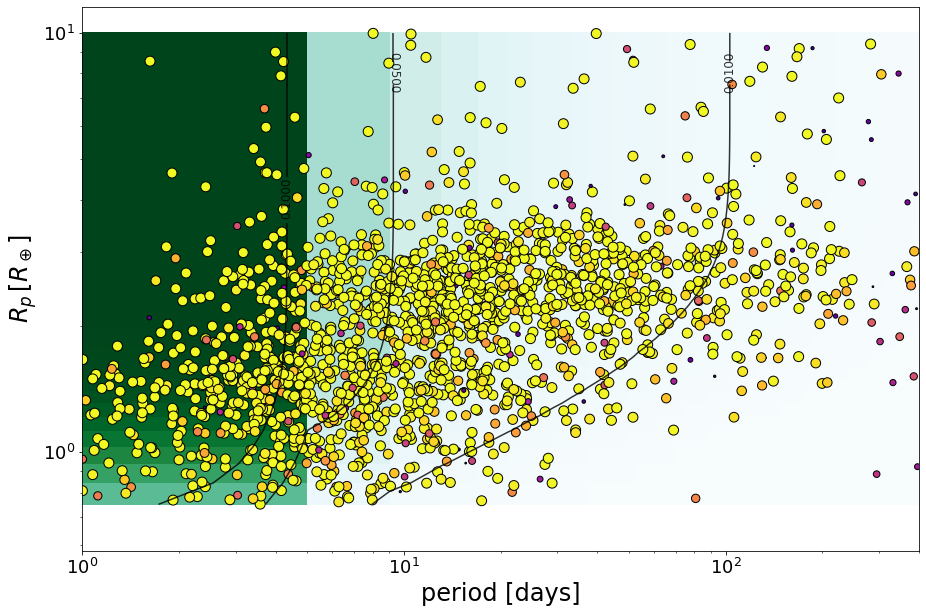

In [20]:
# contourLevels = np.arange(1e-2, 1, 5e-2)
#contourLevels = np.arange(1e-3, 1e-2, 1e-3)
#contourLevels = np.insert(contourLevels, 0, [1e-4, 5e-4])
#contourLevels = [0.001, 0.005, 0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]

contourLevels = [0.01, 0.05, 0.1, 0.25, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
plt.figure(figsize=(15,10))

plt.pcolor(period_grid, rp_grid, summedCompleteness, cmap="BuGn")
c = plt.contour(period_grid, rp_grid, summedCompleteness/ kiclist.size, contourLevels,
               colors="k", alpha=0.8)
ax.errorbar(kois.koi_period, getRadii(kois), 
           yerr = [-kois.corrected_prad_err2, kois.corrected_prad_err1],
         fmt="none", ecolor="k", alpha = 0.15, marker = None)
scf = plt.scatter(kois.koi_period, getRadii(kois), cmap="plasma", 
               c=kois.totalReliability, edgecolors='k', s=100*kois.totalReliability, alpha = 1.0)

#cbh = plt.colorbar(scf);
#cbh.ax.set_ylabel("Reliability", fontsize = 24);

#c = plt.contour(period_grid, rp_grid, numCompVe / kiclist.size,
#               colors="k", alpha=0.8)
#plt.ylim(1, 10)
#plt.xlim(0.1, 500)
plt.clabel(c, fontsize=12, inline=1, fmt="%.4f")
# plt.title("DR25 PC Average detection*vetting efficiency", fontsize = 18)
plt.tick_params(labelsize = 18)
plt.xlabel("period [days]", fontsize = 24)
plt.ylabel("$R_p \, [R_\oplus]$", fontsize = 24);
#plt.savefig("summedCompleteness.png",bbox_inches='tight')
plt.xscale('log')
plt.yscale('log')
plt.show()

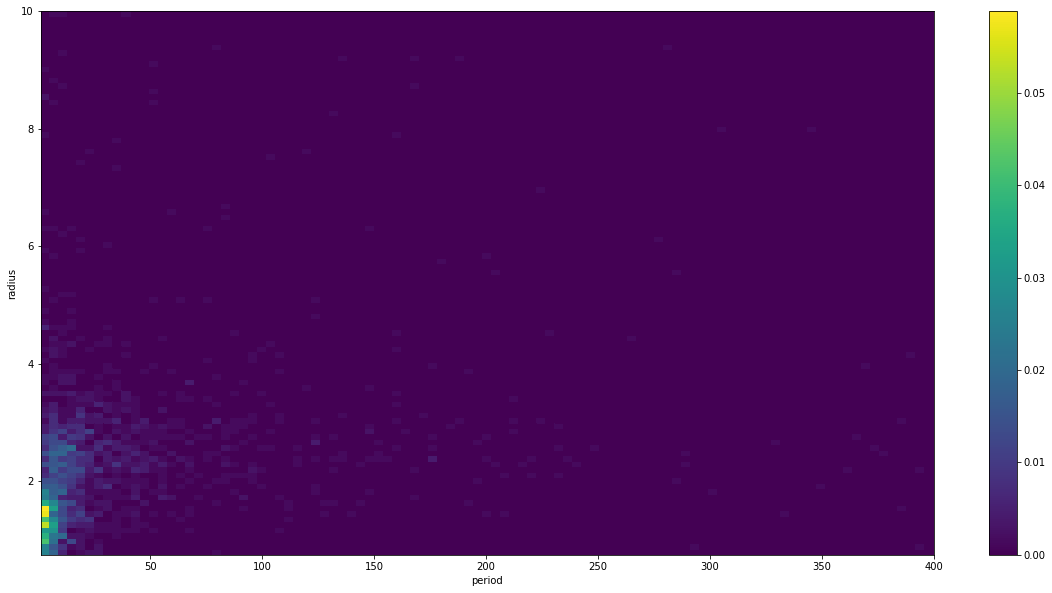

In [21]:
H, xedges, yedges = np.histogram2d(kois.koi_period, getRadii(kois), bins=(period, rp))

#X, Y = np.meshgrid(xedges, yedges)
fig, ax = plt.subplots(figsize=(20, 10))
#ax = fig.add_subplot(132)
im = ax.pcolormesh(period_grid, rp_grid, H)
#plt.xlim(.1,500)
fig.colorbar(im)
plt.xlabel('period')
plt.ylabel('radius')
plt.show()

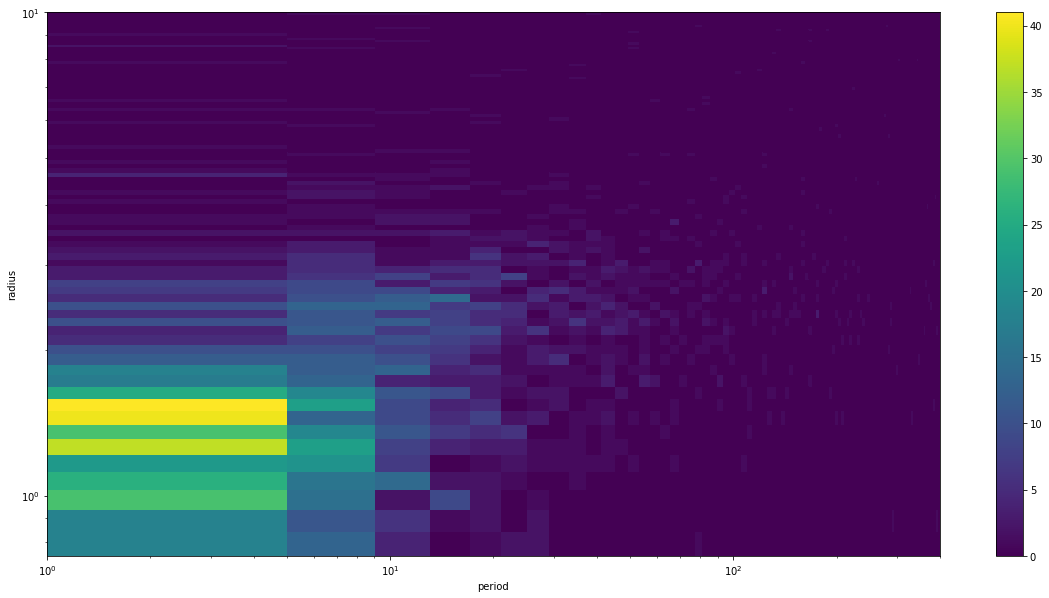

In [22]:
H1, xedges, yedges = np.histogram2d(kois.koi_period, getRadii(kois), bins=(period, rp))

#X, Y = np.meshgrid(xedges, yedges)
fig, ax = plt.subplots(figsize=(20, 10))
#ax = fig.add_subplot(132)
im = ax.pcolormesh(period_grid, rp_grid, H1)
#plt.xlim(.1,500)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('period')
plt.ylabel('radius')
fig.colorbar(im)
plt.show()

In [23]:
# population analysis functions modified from Daniel Foreman Mackey's https://dfm.io/posts/exopop/

# We'll reuse these functions to plot all of our results.
def make_plot(pop_comp, x0, x, y, ax):
#    print("in make_plot, pop_comp:")
#    print(pop_comp.shape)

    pop = 0.5 * (pop_comp[:, 1:] + pop_comp[:, :-1])
#    print("pop:")
#    print(pop.shape)
    pop = np.sum(pop * np.diff(y)[None, :, None], axis=1)
    a, b, c, d, e = np.percentile(pop * np.diff(x)[0], [2.5, 16, 50, 84, 97.5], axis=0)
    
    ax.fill_between(x0, a, e, color="k", alpha=0.1, edgecolor="none")
    ax.fill_between(x0, b, d, color="k", alpha=0.3, edgecolor="none")
    ax.plot(x0, c, "k", lw=1)

def plot_results(samples):
    # Loop through the samples and compute the list of population models.
    samples = np.atleast_2d(samples)
    pop = np.empty((len(samples), period_grid.shape[0], period_grid.shape[1]))
    gamma_earth = np.empty((len(samples)))

    for i, p in enumerate(samples):
        pop[i] = rateModel(period_grid, rp_grid, period_rng, rp_rng, p, model)
        gamma_earth[i] = rateModel(365.25, 1.0, period_rng, rp_rng, p, model) * 365.
    
    fig, axes = plt.subplots(2, 2, figsize=(10, 8))
    fig.subplots_adjust(wspace=0.4, hspace=0.4)
    
    # Integrate over period.
    dx = 0.25
    x = np.arange(rp_rng[0], rp_rng[1] + dx, dx)
    n, _ = np.histogram(koi_rps, x)
    
    fsize = 18
    # Plot the observed radius distribution.
    ax = axes[0, 0]
    make_plot(pop * summedCompleteness[None, :, :], rp, x, period, ax)
    ax.errorbar(0.5*(x[:-1]+x[1:]), n, yerr=np.sqrt(n), fmt=".k",
                capsize=0)
    #ax.set_xlim(rp_rng[0], rp_rng[1])
    ax.set_xlabel("$R_p\,[R_\oplus]$", fontsize = fsize)
    ax.set_ylabel("# of detected planets", fontsize = fsize)
    
    # Plot the true radius distribution.
    ax = axes[0, 1]
    make_plot(pop, rp, x, period, ax)
    #ax.set_xlim(rp_rng[0], rp_rng[1])
    #ax.set_ylim(0, 0.37)
    ax.set_xlabel("$R_p\,[R_\oplus]$", fontsize = fsize)
    ax.set_ylabel("$\mathrm{d}N / \mathrm{d}R$; $\Delta R = 0.25\,R_\oplus$", fontsize = fsize)
    
    # Integrate over period.
    dx = 31.25
    x = np.arange(period_rng[0], period_rng[1] + dx, dx)
    n, _ = np.histogram(koi_periods, x)
    
    # Plot the observed period distribution.
    ax = axes[1, 0]
    make_plot(np.swapaxes(pop * summedCompleteness[None, :, :], 1, 2), period, x, rp, ax)
    ax.errorbar(0.5*(x[:-1]+x[1:]), n, yerr=np.sqrt(n), fmt=".k",
                capsize=0)
    #ax.set_xlim(period_rng[0], period_rng[1])
    #ax.set_ylim(0, 79)
    ax.set_xlabel("$P\,[\mathrm{days}]$", fontsize = fsize)
    ax.set_ylabel("# of detected planets", fontsize = fsize)
    
    # Plot the true period distribution.
    ax = axes[1, 1]
    make_plot(np.swapaxes(pop, 1, 2), period, x, rp, ax)
    #ax.set_xlim(period_rng[0], period_rng[1])
    #ax.set_ylim(0, 0.27)
    ax.set_xlabel("$P\,[\mathrm{days}]$", fontsize = fsize)
    ax.set_ylabel("$\mathrm{d}N / \mathrm{d}P$; $\Delta P = 31.25\,\mathrm{days}$", fontsize = fsize)
    
                
    return gamma_earth, fig

Compute a basic occurrence rate without reliability

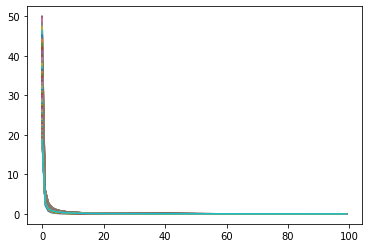

[0.75, -0.53218, -0.5]
14119.356769520742
[ 5.87179793 -0.08590401 -2.36973791]


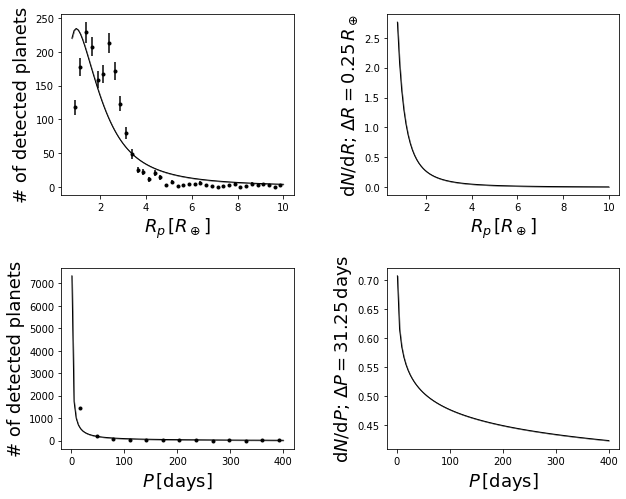

In [24]:
kois = allKois

if model == "dualPowerLaw":
    bounds = [(0, 8), (-5, 5), (-5, 5)]
    
# The ln-likelihood function given at the top of this post.
koi_periods = np.array(kois.koi_period)
koi_rps = np.array(getRadii(kois))
# koi_rps = getRadii(kois)

vol = np.diff(period_grid, axis=0)[:, :-1] * np.diff(rp_grid, axis=1)[:-1, :]


#print(rateModel(koi_periods, koi_rps, period_rng, rp_rng, theta_0, "dualPowerLaw"))
plt.plot(rateModel(period_grid, rp_grid, period_rng, rp_rng, initRateModel(model), "dualPowerLaw") * summedCompleteness)
plt.show()


theta_0 = initRateModel(model)
#theta_0 = [5, 1, 5]
print(theta_0)
print(nll(theta_0))
r = minimize(nll, theta_0, method="L-BFGS-B", bounds=bounds)
print(r.x)
ge, fig = plot_results(r.x)
#[ 0.88074391 -0.50150404  0.11076642]

In [25]:
rateModel(365.25, 1.0, period_rng, rp_rng, r.x, model)*365

4.714052632455007

In [26]:

##################################################################


ndim, nwalkers = len(r.x), nWalkers
pos = [r.x + 1e-5 * np.random.randn(ndim) for i in range(nwalkers)]
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, threads=8)

# Burn in.
pos, _, _ = sampler.run_mcmc(pos, nBurnin)
sampler.reset()

# Production.
start_time = time.time()
pos, _, _ = sampler.run_mcmc(pos, nMcmc)
print("--- %s seconds ---" % (time.time() - start_time))

samples_noreliability = sampler.flatchain   

/Users/anne/anaconda2/envs/python3/lib/python3.6/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]


--- 0.39130711555480957 seconds ---


4.714132610016005


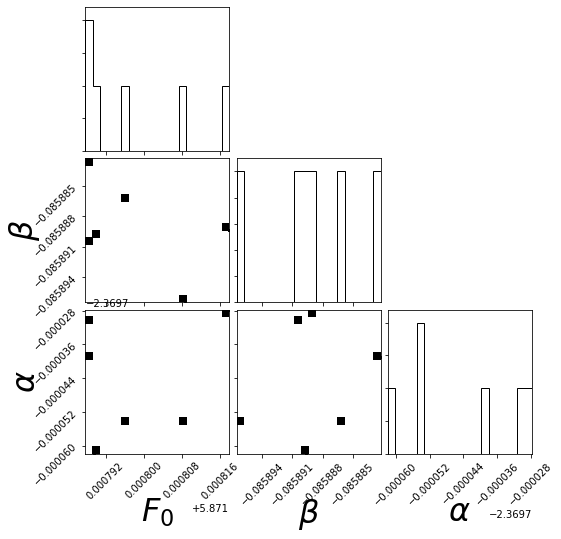

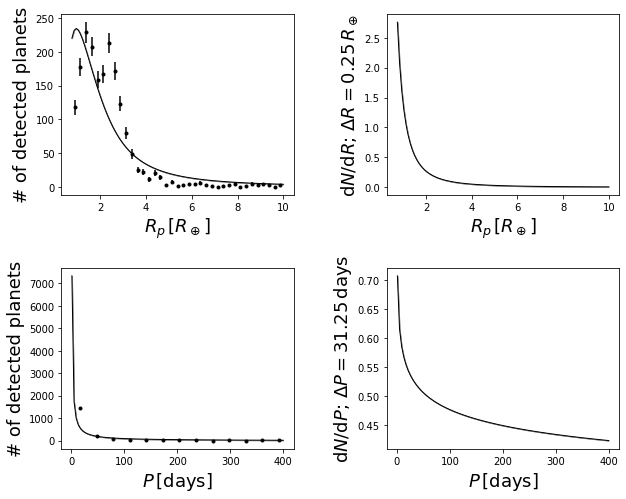

In [27]:
##################################################################
##################################################################

corner.corner(samples_noreliability, labels=getModelLabels(model), label_kwargs = {"fontsize": 32})
#plt.savefig("occPostNoReliability.pdf",bbox_inches='tight')

##################################################################

gamma_earth_no_reliability, fig = plot_results(samples_noreliability)
#plt.savefig("occMargNoReliability.pdf",bbox_inches='tight')
print(np.mean(gamma_earth_no_reliability))

##################################################################

Compute an occurrence rate with reliability

In [28]:
nTrials = 100

f = FloatProgress(min=0, max=nTrials)
display(f)

allKois = kois
for mCount in range(nTrials):
    # randomly select kois
    
    koiSelect = (np.random.rand(len(allKois)) < allKois.totalReliability)
#    koiSelect = (np.random.rand(len(allKois)) < allKois.reliability)
    kois = allKois[koiSelect]
#    kois.to_csv("occurenceRatePosteriors/selectedPcs" + str  (mCount) + ".csv")
#    print(str(mCount) + " of " + str(nTrials) + ", selected " + str(len(kois)) 
#          + " kois out of " + str(len(allKois)) + " after reliability cut")
    
    koi_periods = np.array(kois.koi_period)
    koi_rps = np.array(getRadii(kois))

    theta_0 = initRateModel(model)
    r = minimize(nll, theta_0, method="L-BFGS-B", bounds=bounds)

    ##################################################################


    ndim, nwalkers = len(r.x), 2*len(r.x)
    pos = [r.x + 1e-5 * np.random.randn(ndim) for i in range(nwalkers)]
    sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob)

    # Burn in.
    pos, _, _ = sampler.run_mcmc(pos, 200)
    sampler.reset()

    # Production.
    pos, _, _ = sampler.run_mcmc(pos, 1000)

    samples = sampler.flatchain   
    if mCount == 0:
        allSamples = samples[0:-1:10,:]
    else:
        allSamples = np.concatenate((allSamples, samples[0:-1:10,:]))
    
    f.value += 1

FloatProgress(value=0.0)

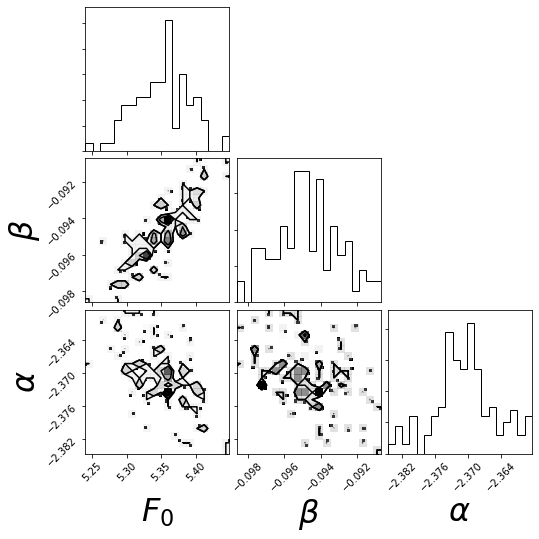

In [29]:
corner.corner(allSamples, labels=getModelLabels(model), label_kwargs = {"fontsize": 32});
#plt.savefig("occPostReliability.pdf",bbox_inches='tight')

In [30]:
modelLabels = getModelLabels(model)
for i in range(0,ndim):
    print("MCMC no reliability " + modelLabels[i] + "=" + printMedianAndErrorbars(samples_noreliability[:,i]))
for i in range(0,ndim):
    print("MCMC with reliability " + modelLabels[i] + "=" + printMedianAndErrorbars(allSamples[:,i]))

MCMC no reliability $F_0$=5.872^{+0.000}_{-0.000}
MCMC no reliability $\beta$=-0.086^{+0.000}_{-0.000}
MCMC no reliability $\alpha$=-2.370^{+0.000}_{-0.000}
MCMC with reliability $F_0$=5.350^{+0.041}_{-0.041}
MCMC with reliability $\beta$=-0.095^{+0.002}_{-0.002}
MCMC with reliability $\alpha$=-2.371^{+0.006}_{-0.005}


In [31]:
#gamma_earth, fig = plot_results(allSamples)
#plt.savefig("occMargReliability.png",bbox_inches='tight')

(100, 100)


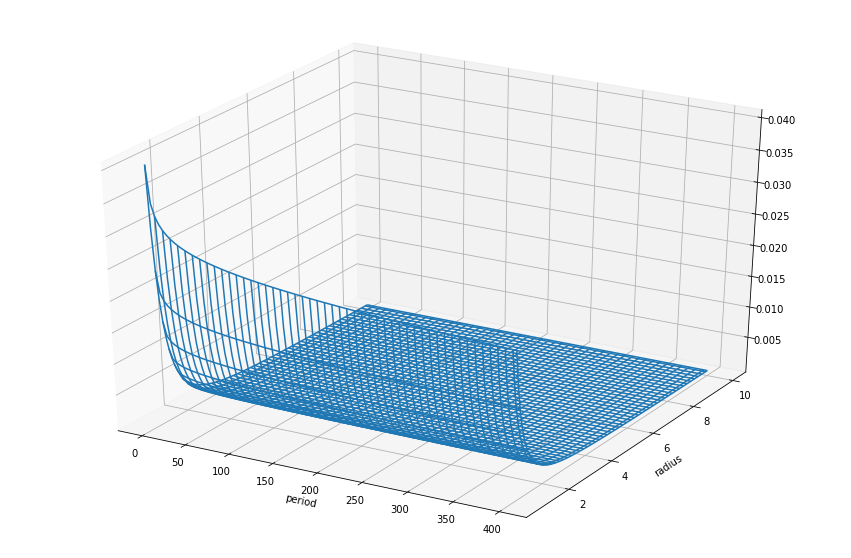

In [36]:
from mpl_toolkits.mplot3d import axes3d
fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot(111, projection='3d')

print(rateGrid.shape)

#ax.plot_wireframe(period_grid, rp_grid, summedCompleteness / kiclist.size, rstride=2, cstride=2)
ax.plot_wireframe(period_grid, rp_grid, rateGrid)
ax.set_xlabel('period')
ax.set_ylabel('radius')
plt.show()

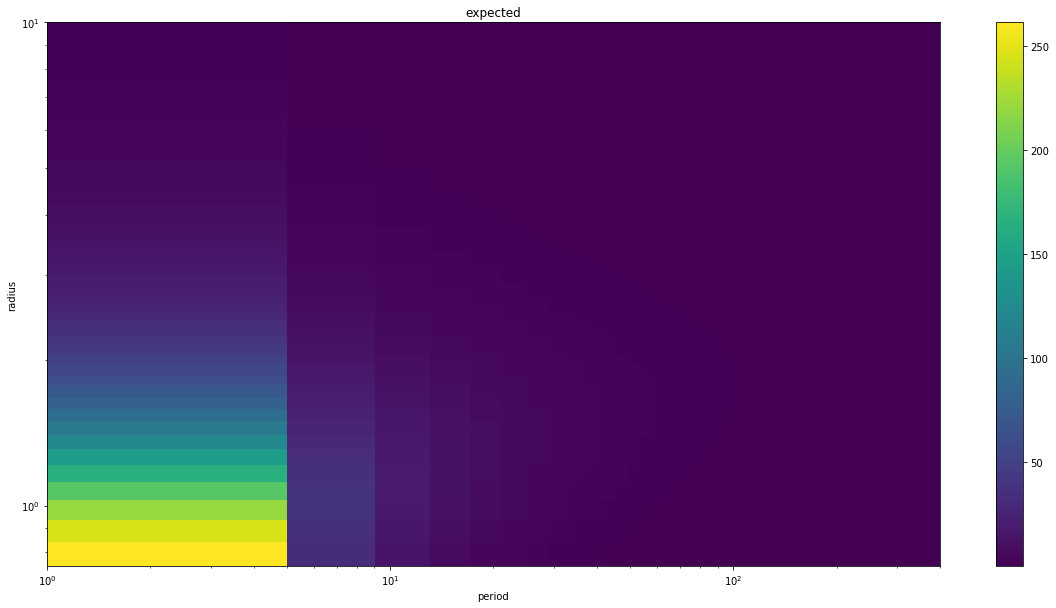

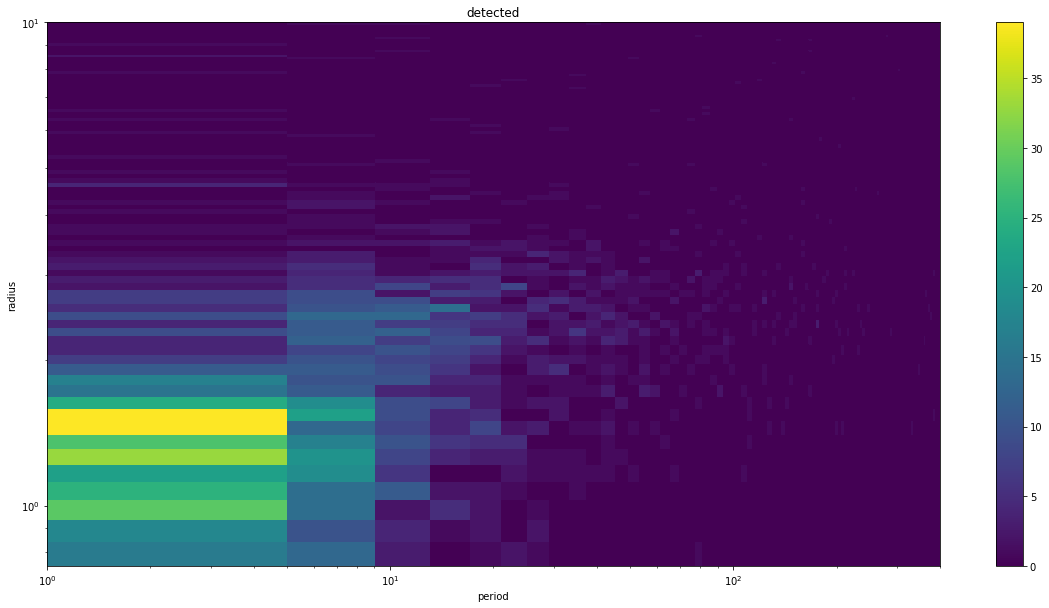

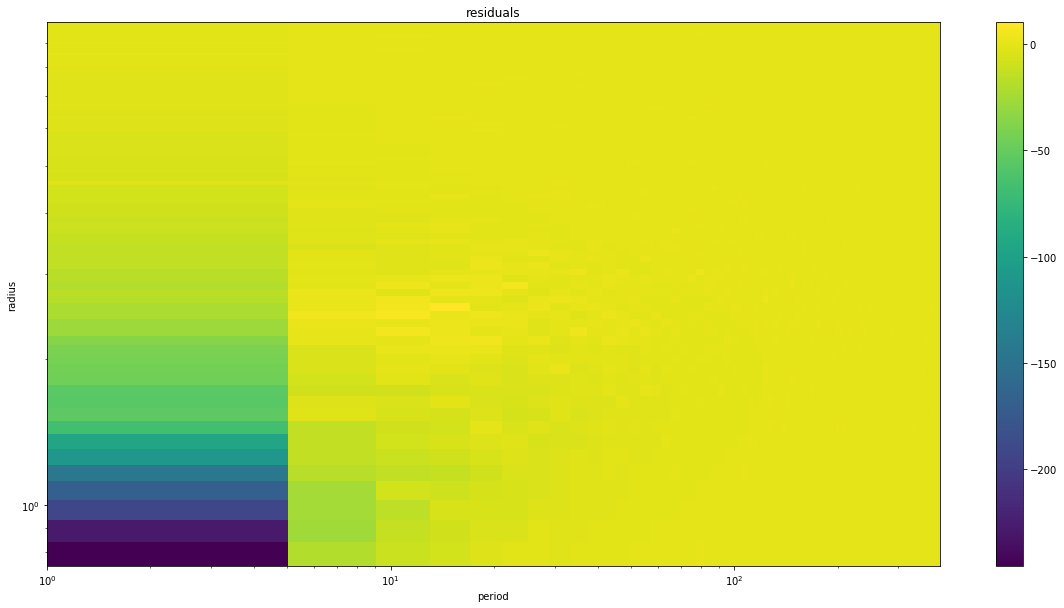

In [35]:
o = (rateModel(period_grid, rp_grid, period_rng, rp_rng, np.median(allSamples, 0), model)*summedCompleteness)
H, xedges, yedges = np.histogram2d(kois.koi_period, getRadii(kois), bins=(period, rp))
res = H-o[:-1, :-1]
res[np.where(res==0)] = np.nan

fig, ax = plt.subplots(figsize=(20, 10))
#ax = fig.add_subplot(132)
im = ax.pcolormesh(period_grid, rp_grid, o)
#plt.xlim(.1,500)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('period')
plt.ylabel('radius')
fig.colorbar(im)
plt.title("expected")

fig, ax = plt.subplots(figsize=(20, 10))
#ax = fig.add_subplot(132)
im = ax.pcolormesh(period_grid, rp_grid, H)
#plt.xlim(.1,500)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('period')
plt.ylabel('radius')
fig.colorbar(im)
plt.title('detected')

fig, ax = plt.subplots(figsize=(20, 10))
#ax = fig.add_subplot(132)
im = ax.pcolormesh(period_grid[:-1, :-1], rp_grid[:-1, :-1], H-o[:-1, :-1])
#plt.xlim(.1,500)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('period')
plt.ylabel('radius')
fig.colorbar(im)
plt.title('residuals')
plt.show()

In [ ]:
print("F = " + printMedianAndErrorbars(samples_noreliability[:,0]))
print("radius exp (alpha) = " + printMedianAndErrorbars(samples_noreliability[:,2]))
print("period exp (beta) = " + printMedianAndErrorbars(samples_noreliability[:,1]))

In [ ]:
plt.hist(np.log10(gamma_earth_no_reliability), 50, histtype="step", color="k", density=True)
plt.gca().set_yticklabels([])
plt.title("the rate of Earth analogs: " + str(10**np.mean(np.log10(gamma_earth_no_reliability))))
plt.xlabel(r"$\log_{10}\Gamma_\oplus = \left. \log_{10}\mathrm{d}N / \mathrm{d}\ln P \, \mathrm{d}\ln R_p \right |_\oplus$");

print("Mean Gamma_Earth = {0}".format(10**np.mean(np.log10(gamma_earth_no_reliability))))
print("Gamma at p=365 days, r=1Re without reliability = " + printMedianAndErrorbars(gamma_earth_no_reliability))

In [ ]:
F1Dist_nr = integrateRateModel([50.,200.], [1., 2.], samples_noreliability, model)
print("1-2Re, 50-200 Days without reliability = " + printMedianAndErrorbars(F1Dist_nr))

F1Dist_nr = integrateRateModel([50.,300.], [0.75, 2.5], samples_noreliability, model)
print("0.75-2.5Re, 50-300 Days without reliability = " + printMedianAndErrorbars(F1Dist_nr))